# wiki_movie_plots

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')

In [3]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
print('{}년 영화부터 최근 {}년 영화까지 데이터 확보'.format(df['Release Year'].min(),df['Release Year'].max()))

1901년 영화부터 최근 2017년 영화까지 데이터 확보


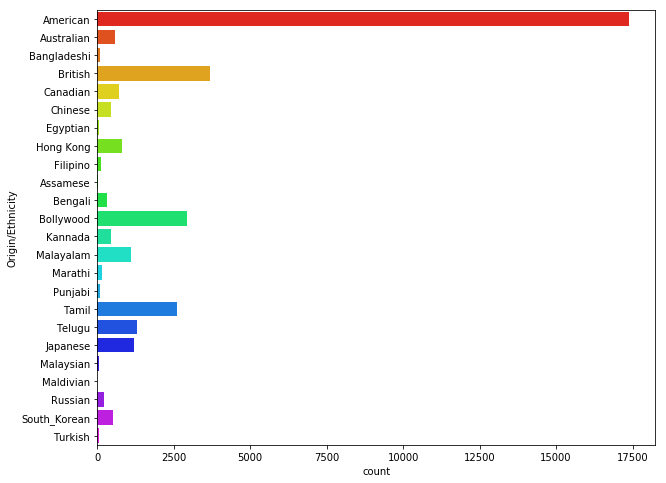

In [5]:
plt.figure(figsize = (10,8))
sns.countplot(y = df['Origin/Ethnicity'], palette = 'gist_rainbow')
plt.show()

America 영화가 제일 많은 것을 알 수 있다. 영국, 인도 영화도 많다.

## TF-IDF 구현

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Plot'])
print(tfidf_matrix.shape)

(34886, 5000)


34886개의 영화의 내용을 설명하기 위해 총 133554개의 단어가 사용되었습니다.

In [127]:
from sklearn.metrics.pairwise import linear_kernel
cos_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [124]:
row_number = pd.Series(df.index, index=df['Title']).drop_duplicates()
row_number.head()

Title
Kansas Saloon Smashers              0
Love by the Light of the Moon       1
The Martyred Presidents             2
Terrible Teddy, the Grizzly King    3
Jack and the Beanstalk              4
dtype: int64

In [10]:
def rec_title(title, cos_sim=cos_sim):
    # 제목에 부여된 번호를 저장합니다.
    idx = row_number[title]

    # 모든 영화와 해당 영화의 유사도를 저장합니다.
    score = list(enumerate(cos_sim[idx]))

    # 유사도에 따라 영화들을 정렬합니다.
    score = sorted(score, key=lambda x: x[1], reverse=True)

    # 내용상 가장 유사한 10개의 영화를 받아옵니다.
    title_list = score[1:11]

    # 해당 영화들의 인덱스를 저장합니다.
    movie_idx = [n[0] for n in title_list]

    # 인덱싱을 이용해 영화 제목을 반환합니다.
    return df['Title'].iloc[movie_idx]

In [133]:
rec_title('Star Wars: The Last Jedi')

10136                                  Return of the Jedi
9428     Star Wars Episode IV: A New Hope (aka Star Wars)
8193                                       Cool Hand Luke
15553                                        The Wackness
12696                                           First Kid
7254                                No Name on the Bullet
13739                                          The Skulls
9774                              The Empire Strikes Back
22253                                         Afghan Luke
15940                                          Step Up 3D
Name: Title, dtype: object

## 토큰화 이용

In [66]:
import nltk
from nltk.tokenize import RegexpTokenizer
import re
from nltk.corpus import stopwords
from tqdm import tqdm

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

C:\Users\ksh\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [30]:
s_w = set(stopwords.words('english'))

In [64]:
tokenizer = RegexpTokenizer("[\w']+")

In [ ]:
token_plot = []

In [40]:
for text in tqdm(range(len(df.Plot))):
    token_plot.append(tokenizer.tokenize(df.Plot[text]))

100%|██████████████████████████████████████████████████████████████████████████| 34886/34886 [00:04<00:00, 7005.19it/s]


In [56]:
t_s_w = []

In [57]:
for word in tqdm(range(len(token_plot))):
    t_s_w.append([text for text in token_plot[word] if not text in s_w])

100%|█████████████████████████████████████████████████████████████████████████| 34886/34886 [00:01<00:00, 30484.44it/s]


In [62]:
df['token_plot'] = t_s_w

In [67]:
doc_df = df[['Title','token_plot']].values.tolist()
tagged_data = [TaggedDocument(words=_d, tags=[uid]) for uid, _d in doc_df]

In [68]:
max_epochs = 10

model = Doc2Vec(
    window=7,
    size=200,
    alpha=0.025, 
    min_alpha=0.025,
    min_count=3,
    dm =1,
    negative = 5,
    seed = 123)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

C:\Users\ksh\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


C:\Users\ksh\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [69]:
model.random.seed(123)

In [116]:
return_docs = model.docvecs.most_similar('The Admiral: Roaring Currents',topn = 10)
for s_m in return_docs:
    for context in df[df['Title'] == s_m[0]]['Plot']:
        print('유사 영화 제목은', s_m[0])
        print('유사도는', s_m[1])
        print('영화 내용은', context)
        print('#############------############------############'*2)

유사 영화 제목은 300: Rise of an Empire
유사도는 0.46581774950027466
영화 내용은 Queen Gorgo of Sparta tells her men about the Battle of Marathon, in which King Darius of Persia was killed by General Themistocles of Athens ten years earlier. Darius's son, Xerxes, witnesses his father's death, and is advised to not continue the war, since only "the gods can defeat the Greeks". Darius's naval commander, Artemisia, claims that Darius' last words were in fact a challenge and sends Xerxes on a journey through the desert. Xerxes finally reaches a cave and bathes in an otherworldly liquid, emerging as the 8-foot tall "God-King". He returns to Persia and declares war on Greece to avenge his father.
As Xerxes's forces advance towards Thermopylae, Themistocles meets with the council and convinces them to provide him with a fleet to engage the Persians at the sea. Themistocles then travels to Sparta to ask King Leonidas for help, but is informed by Dilios that Leonidas is consulting the Oracle, and Gorgo is relu

Dilios, now back at Sparta, concludes his tale before the Council. Inspired by Leonidas' sacrifice, Greece mobilizes. One year later, the Persians face an army of 30,000 free Greeks led by a vanguard of 10,000 Spartans. After one final speech commemorating the 300, Dilios, now head of the Spartan Army, leads them to war, against the Persians across the fields of Plataea.
#############------############------#########################------############------############
유사 영화 제목은 G.I. Samurai
유사도는 0.43886542320251465
영화 내용은 On their way to a manoeuver, a wildly mixed group of Japanese soldiers with a tank, an APC, a patrol boat and a helicopter suddenly find themselves stranded 400 years in the past and under attack by samurai forces. Their designated leader, Lieutenant Yoshiaki Iba (Sonny Chiba), befriends and joins forces with Nagao Kagetora, the war leader of lord Koizumi. Seeing the stranded soldiers' war machinery in action, Kagetora persuades Iba to aid him in his struggle for supr

At Sabai they learn that Rokugo intends to move a bonfire, which serves as a warning to passing ships against dangerous rocks, so that a gold ship will hit the rocks and sink. After recovering the gold, Rokugo intends to slaughter the peasants who help him in this endeavor. The combined efforts of Magobei, Samon, Oriha, and Rokuzo result in the correct bonfire being lit, the fake bonfire being put out, and the innocent peasants' lives being saved. Thus the gold-bearing ship evades the rocks. In a final showdown, amid falling snow, Magobei slays Rokugo, but is wounded by one of Rokugo's throwing knives.
#############------############------#########################------############------############
유사 영화 제목은 The Warrior and the Wolf
유사도는 0.42522066831588745
영화 내용은 General Zhang is the commander of a northern border's army camp which repels the attacking barbarians every year. When snowfall make the support of the base with supplies impossible, the troops return home.
Lu Shenkang is a 

The original two-part 288 minute version was released as a two-disc set on DVD and Blu-ray in the United Kingdom on 5 October 2009,[9] and in the United States and Canada on 23 March 2010.[10]
#############------############------#########################------############------############
유사 영화 제목은 The Fourteen Amazons
유사도는 0.4210156798362732
영화 내용은 The Yang family, men and women, had served their country (Song Dynasty) loyally for generations. During the war with Western Xia, General Yang Tsung-pao is ambushed and killed. His death leaves his only son, Yang Wen as the only male heir left to the Yang family. His widow, Mu Kuei-ying, the grand matriarch and the entire family set out to avenge his death and defend the country. Due to the interference of a corrupt official, Wang Ching, the Yangs were unable to have the emperor's consent to use the imperial army.
Thus, they set off with whatever volunteer troops they could muster. Knowing of Mu Kuei-ying's reputation as a warrior and tac

In [135]:
return_docs = model.docvecs.most_similar('Star Wars: The Last Jedi',topn = 10)
for s_m in return_docs:
    for context in df[df['Title'] == s_m[0]]['Plot']:
        print('유사 영화 제목은', s_m[0])
        #print('유사도는', s_m[1])
        #print('영화 내용은', context)
        print('#############------############------############'*2)

유사 영화 제목은 Return of the Jedi
#############------############------#########################------############------############
유사 영화 제목은 Star Wars: Episode III – Revenge of the Sith
#############------############------#########################------############------############
유사 영화 제목은 Star Wars Episode IV: A New Hope (aka Star Wars)
#############------############------#########################------############------############
유사 영화 제목은 Star Wars: The Force Unleashed II
#############------############------#########################------############------############
유사 영화 제목은 Star Wars: Episode I – The Phantom Menace
#############------############------#########################------############------############
유사 영화 제목은 Star Wars: Episode I – The Phantom Menace 3D
#############------############------#########################------############------############
유사 영화 제목은 The Empire Strikes Back
#############------############------#########################------##########